# Stability changing MaxLevel 

In [1]:
import os
import sys
import gc
import math as m
import numpy as np
import scipy
import pandas as pd
import pylab
from scipy import *
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
sys.path.append('/projects/DEIKE/cmartinb/jupyter_notebook/project_specific/turbulence')
sys.path.append('/projects/DEIKE/cmartinb/functions')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prepare import load_object, save_object, field
from defs import Case, Interface2D
from matplotlib.colors import Normalize, LinearSegmentedColormap
from phase import extract_phase
from funciones import * 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab
from scipy.signal import find_peaks
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from branches import *

import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate
os.chdir('/projects/DEIKE/cmartinb/')

In [2]:
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 30,
         'axes.titlesize':30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral', 
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, # Enable LaTeX rendering
}

plt.rcParams.update(params)
pylab.rcParams.update(params)


In [3]:
graph_path = f'/projects/DEIKE/cmartinb/notebooks/graphs/stability'
if not os.path.exists(graph_path):
    os.makedirs(graph_path)

In [4]:
# Define your parameter lists
kpHs_list = ['0p16']
uoc_list = ['0p50']


# Define other parameters
symbols = ['o', 's', '^']
labels = ['First', 'Second', 'Third']

0p16 0p50 10
0p16 0p50 11
0.0 1.0
0.0 1.0


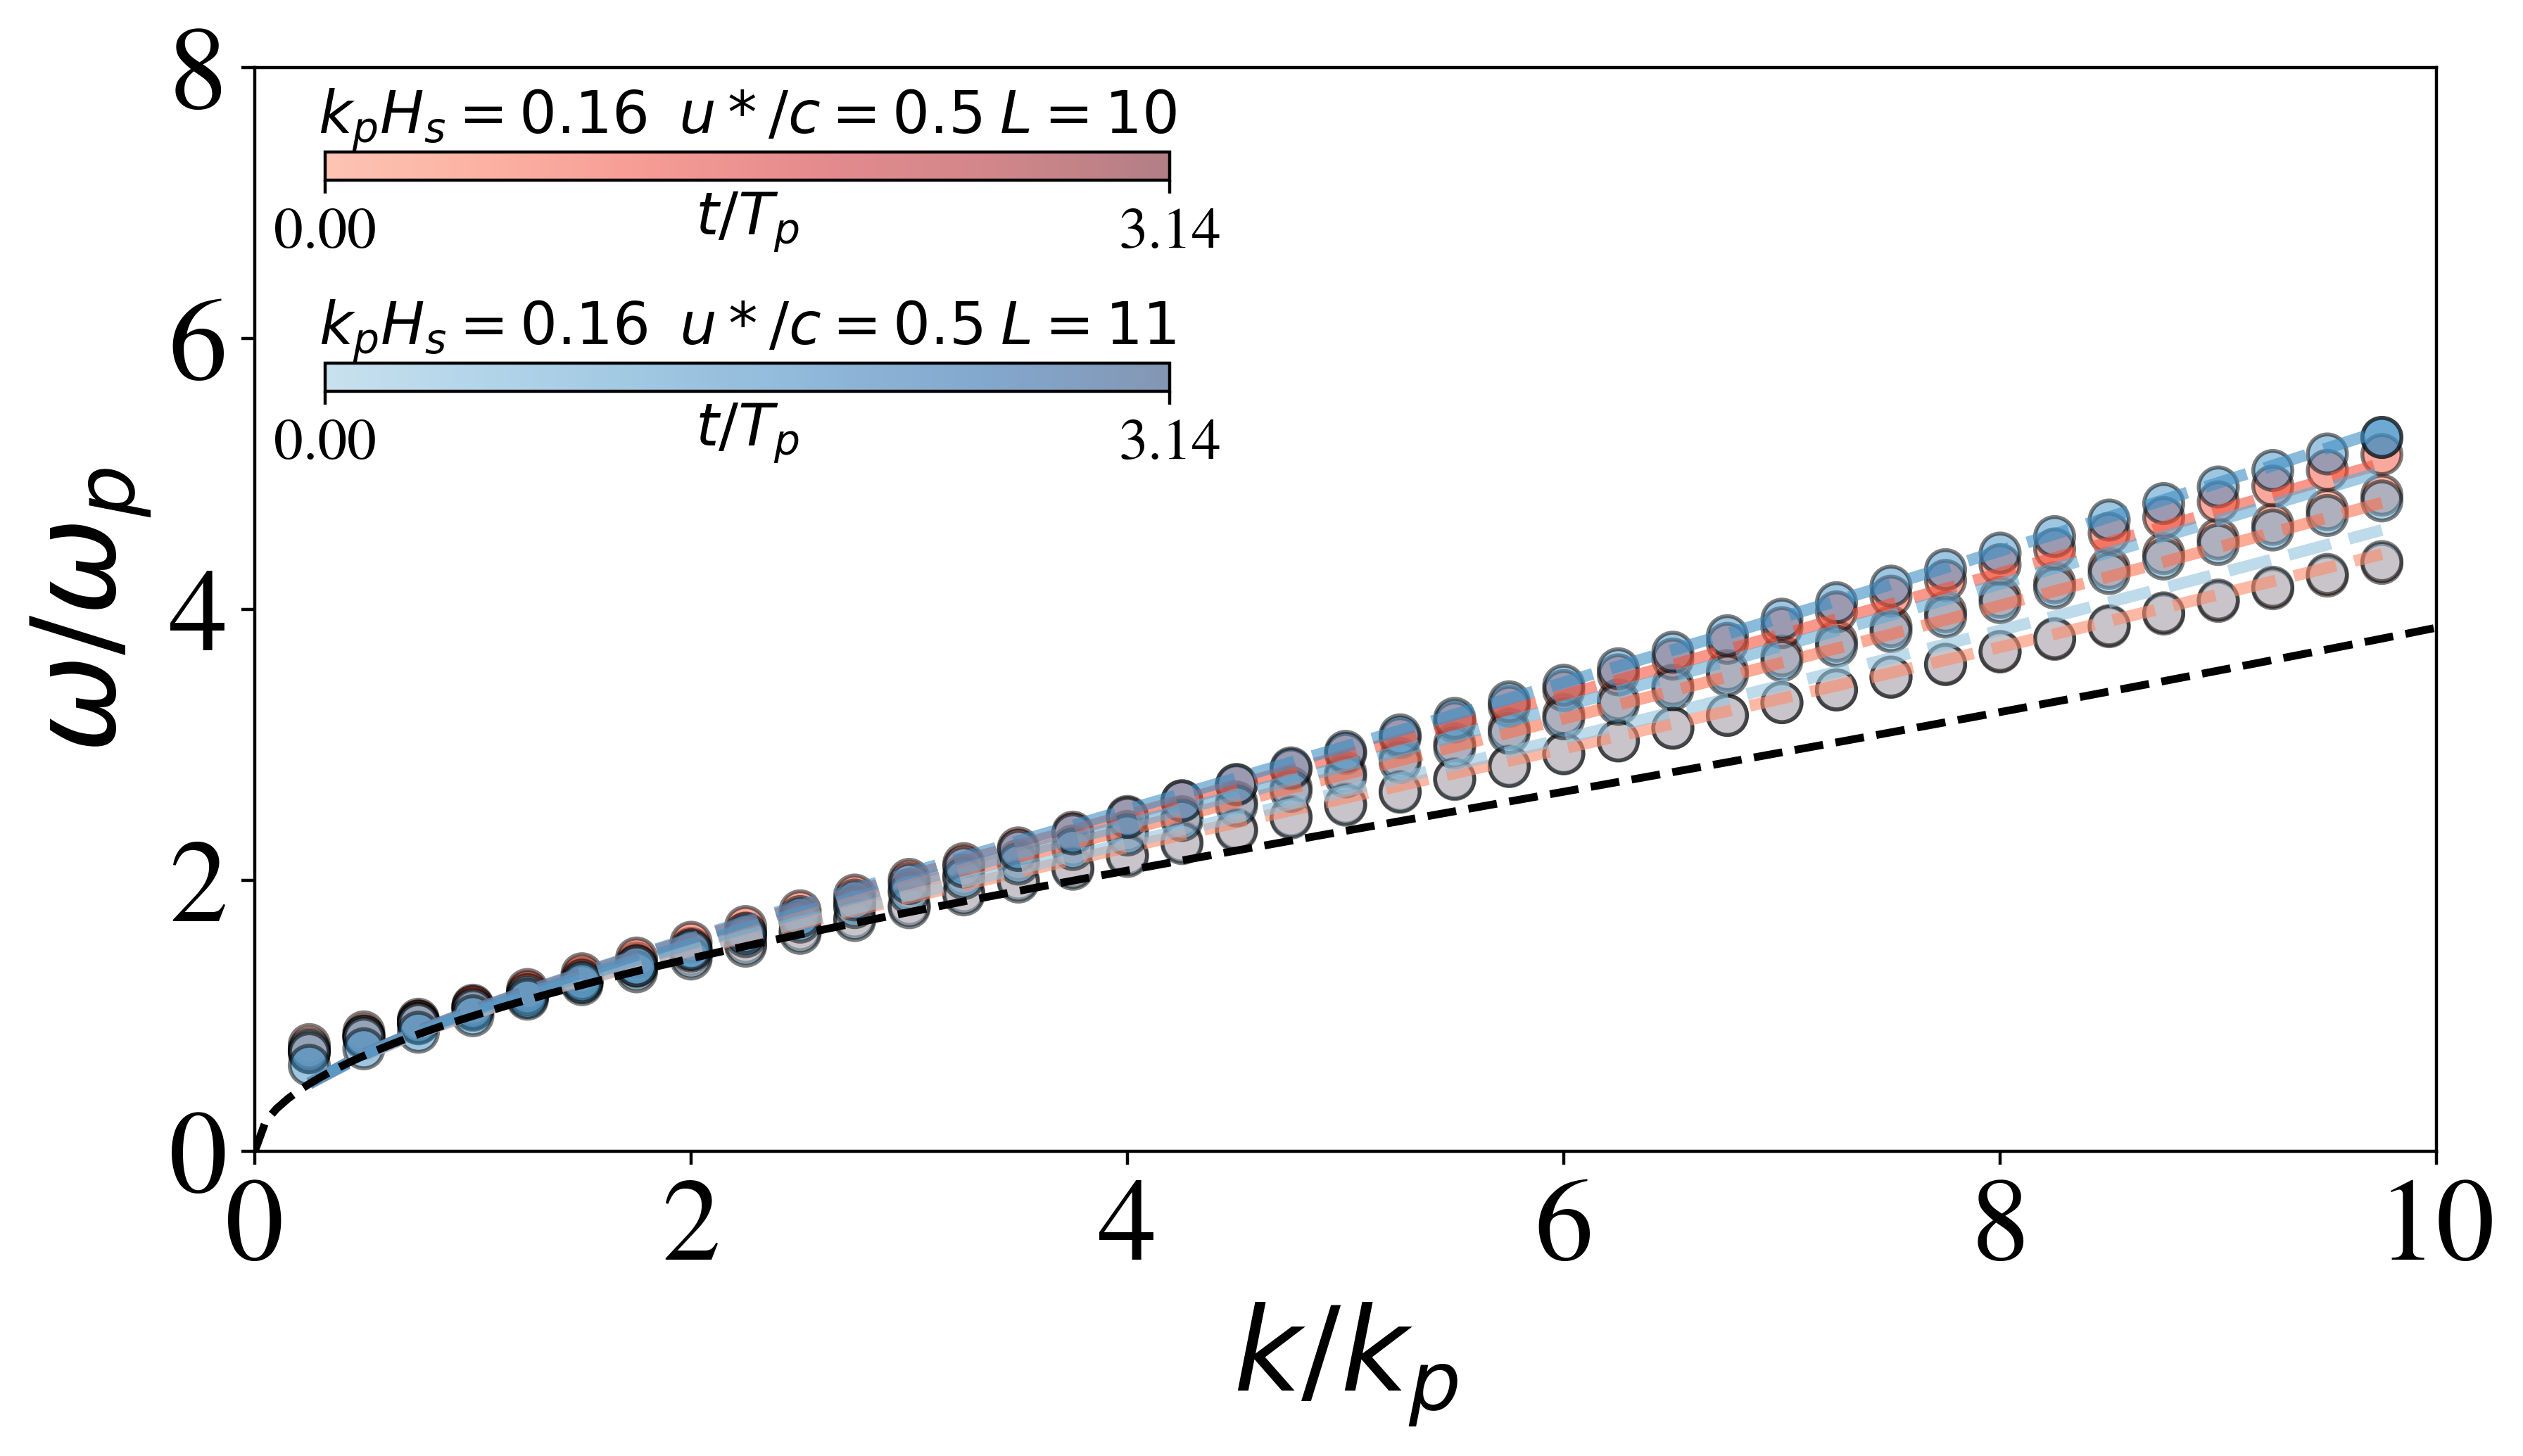

In [5]:
from matplotlib.colorbar import Colorbar
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import os
import math as m
mpl.rcParams['text.usetex'] = False
# Rutas y definición de colormaps
graph_path = './'
csv_dir = '/projects/DEIKE/cmartinb/branches_data/'

cmap_16_50_L10 = LinearSegmentedColormap.from_list("reds_darker", cm.Reds(np.linspace(0.4, 1, 100)))
cmap_16_50_L11 = LinearSegmentedColormap.from_list("blues_darker", cm.Blues(np.linspace(0.4, 1, 100)))

# Asociar cada nivel al colormap deseado
colormaps = {
    10: cmap_16_50_L10,
    11: cmap_16_50_L11,
}

palettes = {
    r'$k_pH_s =0.16$ $u*/c=0.50$ $L=10$': cmap_16_50_L10,
    r'$k_pH_s =0.16$ $u*/c=0.50$ $L=11$': cmap_16_50_L11
}

# Parámetros generales y creación de la figura
reA = 720
fig, ax = plt.subplots(figsize=(10, 5))
maxLevel = [10, 11]
scatter_plots = {}  # Aquí se guardará un scatter representativo por nivel

# Parámetros de entrada
kpHs = '0p16'
uoc = '0p50'
Bo = 200
reW = '2.5e4'
u = 0.25
kp = 4
lambdap = 2 * m.pi / kp
rho1 = 1
rho2 = 1.25e-3
ln = 150
overlap = 0.5

for L in maxLevel:
    work_dir = f'/projects/DEIKE/nscapin/broadband_reorder/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{L}/'
    data = np.loadtxt(os.path.join(work_dir, 'eta/global_int.out'))
    istep_c = data[:, 1]
    time = data[:, 0]
    
    ak, c, omegap, nu_water, g, uoc_val, sigma, Tp = calculate_parameters(kpHs, uoc, u, kp, Bo, rho1, rho2)
    #sigma = (g - 1.25e-3) / (Bo * kp**2)
    print(kpHs, uoc,L)
    
    csv_file = os.path.join(csv_dir, f'branches_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{L}.csv')
    df_branches = pd.read_csv(csv_file)
    
    k_values_first = df_branches['k_values_first'].to_numpy()
    interval_indices_first = df_branches['interval_indices_first'].to_numpy()
    k_values_second = df_branches['k_values_second'].to_numpy()
    interval_indices_second = df_branches['interval_indices_second'].to_numpy()
    k_values_third = df_branches['k_values_third'].to_numpy()
    interval_indices_third = df_branches['interval_indices_third'].to_numpy()
    normalized_omega_first = df_branches['omega_first'].to_numpy()
    normalized_omega_second = df_branches['omega_second'].to_numpy()
    normalized_omega_third = df_branches['omega_third'].to_numpy()
    
    file_path = f'/projects/DEIKE/cmartinb/mean_velocity/mean_velocity_Bo{Bo}_kpHs{kpHs}_uoc{uoc}_L{L}.csv'
    df_meanvelocity = pd.read_csv(file_path)
    phi_avg = df_meanvelocity['phi_avg']
    ux_avg = df_meanvelocity['ux_avg']
    u_atzero = df_meanvelocity['u_atzero']
    
    # Usar el colormap correspondiente para este nivel
    colormap = colormaps[L]
    # Definimos una normalización fija para valores entre 0 y 1
    norm = mcolors.Normalize(vmin=0, vmax=1)
    # Creamos un arreglo de valores normalizados para asignar colores a cada intervalo
    color_values = np.linspace(0, 1, len(u_atzero))
    
    # Generar etiquetas para cada intervalo
    start_idx = 0
    interval_ranges = []
    for i in range(len(u_atzero)):
        end_idx = start_idx + ln
        if end_idx > len(time):
            end_idx = len(time)
        time_subdivision = time[int(start_idx):int(end_idx)]
        interval_ranges.append(
            f'I = [{(time_subdivision[0]-time[0])*omegap/(2*m.pi):.2f}, {(time_subdivision[-1]-time[0])*omegap/(2*m.pi):.2f}] $(t/T_{{p}})$'
        )
        start_idx += (ln - overlap)
        if start_idx >= len(time):
            break
    start_idx = 0
    
    # Graficar la rama "first" (para cada intervalo)
    for i in range(0,5,2):
        end_idx = start_idx + ln
        if end_idx > len(time):
            end_idx = len(time)
        time_subdivision = time[int(start_idx):int(end_idx)]
        idx_first = interval_indices_first == i
        idx_second = interval_indices_second == i
        idx_third = interval_indices_third == i
        
        if np.any(idx_first):
            k_first = k_values_first[idx_first]
            # Convertir las cadenas a arrays numéricos
            ux_avg_i = np.array([float(x) for x in ux_avg[i].replace("\n", "").replace(" ", "").strip("[]").split(",")])
            phi_avg_i = np.array([float(x) for x in phi_avg[i].replace("\n", "").replace(" ", "").strip("[]").split(",")])
            integral_num = []
            for k in k_first:
                integrand_values = ux_avg_i * np.exp(2 * k * 4 * phi_avg_i)
                doppler_shift_speed = 4 * k * np.trapz(integrand_values, phi_avg_i)
                integral_num.append(doppler_shift_speed)
            # Se usa un arreglo del mismo tamaño que k_first para asignar el color
            val = color_values[i]
            scatter = ax.scatter(k_first, normalized_omega_first[idx_first], s=100, alpha=0.5,
                                 c=np.full(k_first.shape, val), cmap=colormap, norm=norm,
                                 edgecolor='black', marker=symbols[0],
                                 label=f'{kpHs}, {uoc} - {interval_ranges[i]}' if i == 0 else "")
            # Guardar un scatter representativo para este nivel
            #if ((kpHs, uoc), L) not in scatter_plots:
            scatter_plots[((kpHs, uoc), L)] = scatter
            integral_num = []
            line_color = colormap(val)                  # te devuelve un RGBA
            for (ki,omegai) in zip(k_first,normalized_omega_first[idx_first]):
                h_val = -1
                #print( k)
                integrand_values = (ux_avg_i) * np.exp(2* ki *4 * phi_avg_i)
                doppler_shift_speed =  4*ki * np.trapz(integrand_values, phi_avg_i)
                #print('time',time[end_idx] - time[0], 'k', k, 'Integral', doppler_shift_speed )
                integral_num.append(doppler_shift_speed)
                #print(integral_num)
        
            plt.plot(k_first, (np.sqrt(g * 4*k_first + sigma * (4*k_first)**3) + 2 * np.array(integral_num) * k_first*4 ) / omegap,
                '--', alpha=0.6, linewidth=3,color=line_color)
    
        # Aquí podrías graficar también las ramas "second" y "third" si lo deseas.
        
        start_idx += (ln - overlap)
        i += 1
        if start_idx >= len(time):
            break

# Graficar la relación de dispersión teórica (ejemplo)
k_diss = np.linspace(0, 40, 200)
dispersion_relation = np.sqrt(k_diss * g)
sigma = (1 - 1.25e-3) / (200 * 4**2)
dispersion_relation_tension = np.sqrt(k_diss * g + sigma / rho1 * k_diss**3)
ax.plot(k_diss / 4, dispersion_relation_tension / omegap, '--', lw=2, c='black')
ax.set_ylim([0, 8])
ax.set_xlabel(r'$k/k_{p}$')
ax.set_ylabel(r'$\omega/\omega_{p}$')

colorbar_length = 0.3 
colorbar_pad = 0.15

def saturate_cmap(cmap, saturation=4):
    """Aumenta la saturación de un colormap."""
    colors_array = cmap(np.linspace(0, 1, 256))
    hsv = mcolors.rgb_to_hsv(colors_array[:, :3])
    hsv[:, 1] = np.clip(hsv[:, 1] * saturation, 0, 1) 
    saturated_colors = mcolors.hsv_to_rgb(hsv)
    return mcolors.LinearSegmentedColormap.from_list("saturated_cmap", saturated_colors)

for idx, (((kpHs, uoc), L_val), scatter) in enumerate(scatter_plots.items()):
    #((kpHs, uoc), L_val) = key
    vmin, vmax = scatter.norm.vmin, scatter.norm.vmax 
    saturated_cmap = saturate_cmap(scatter.get_cmap(), saturation=1.2)
    ak,  c, omegap, nu_water, g, uoc_val, sigma, Tp= calculate_parameters(kpHs, uoc , u ,kp, Bo, rho1, rho2)
    cbar_ax = fig.add_axes([0.15, 0.8 - idx * colorbar_pad, colorbar_length, 0.02])
    cbar = Colorbar(cbar_ax, scatter, orientation="horizontal")
    
    cbar.set_ticks([vmin, vmax]) 
    print(vmin,vmax)
    cbar.set_ticklabels([f"{vmin*omegap/2*m.pi:.2f}", f"{vmax*omegap/2*m.pi:.2f}"])  
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.set_xlabel(r"$t/T_{p}$", fontsize=15, labelpad=-18)
    cbar.ax.set_title(rf'$k_pH_s ={ak}$  $u*/c={uoc_val}$ $L = {L_val}$', fontsize=15, pad=5)
    #cbar.ax.set_title(f'$k_pH_s = {kpHs}$ $u*/c = {uoc}$ $L = {L_val}$', fontsize=15, pad=5)
    
ax.set_ylim([0, 8])
ax.set_xlim([0, 10])
plt.savefig(os.path.join(graph_path, 'L10vsL11.png'), dpi=300, bbox_inches='tight')
plt.show()



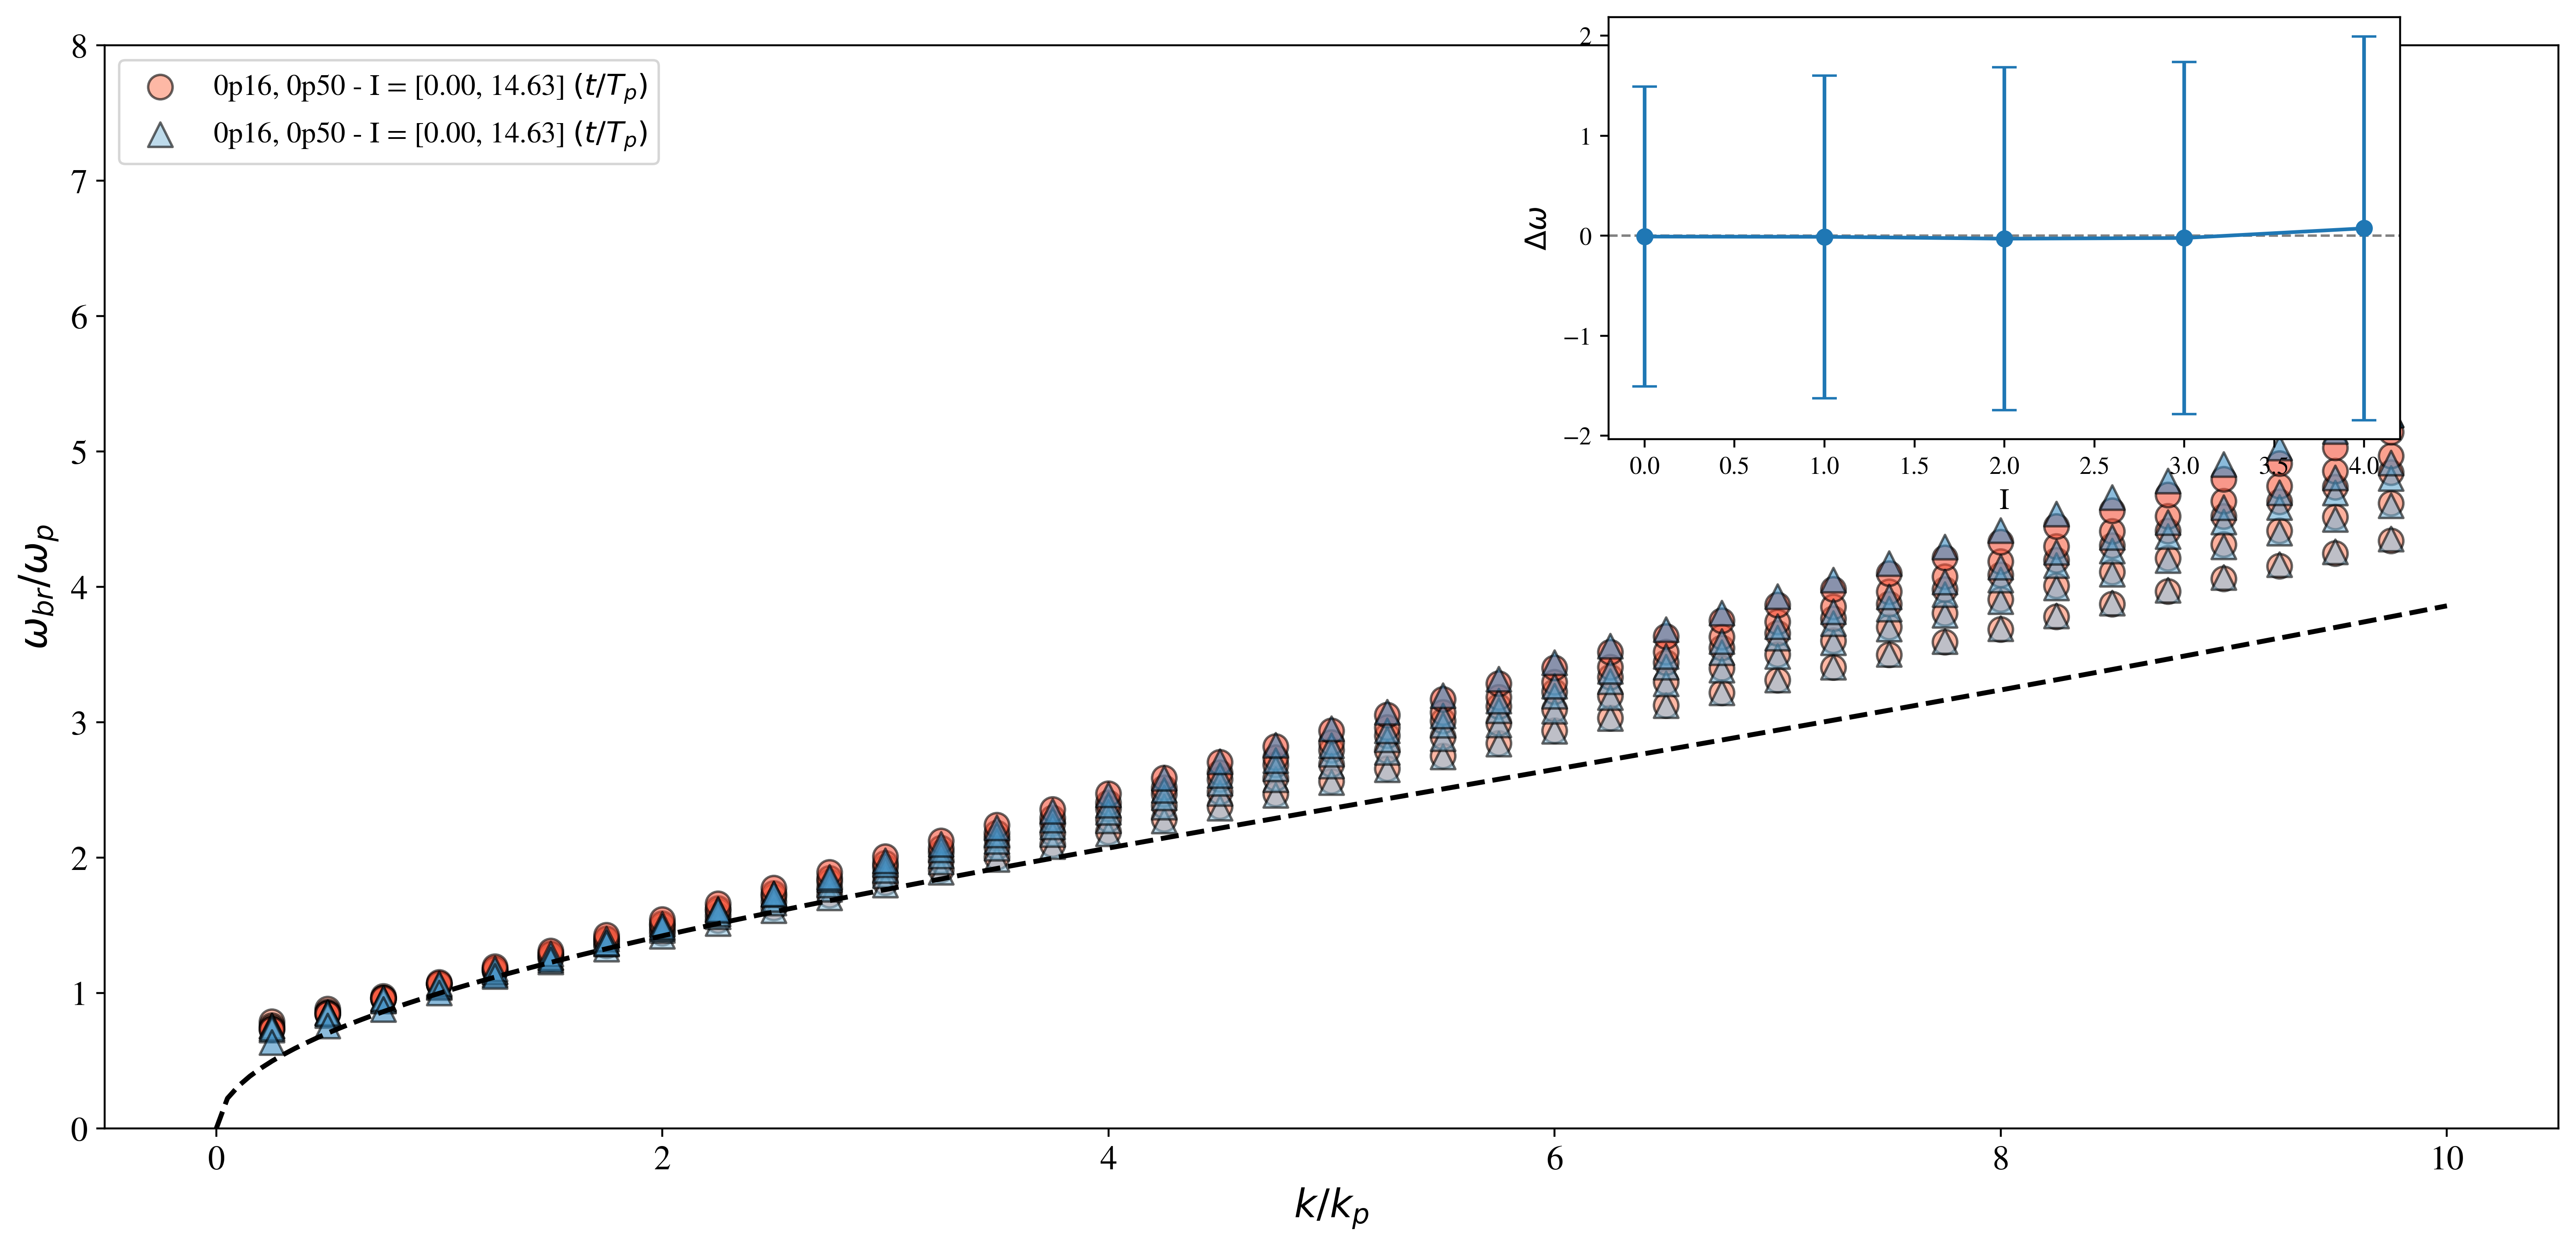

In [6]:
from matplotlib.colorbar import Colorbar
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import os
import math as m

# Función de ejemplo; reemplázala por tu implementación real
def calculate_parameters(kpHs, uoc, u, kp, Bo, rho1, rho2):
    ak = 1
    c = 1
    omegap = 2 * m.pi  # Ejemplo: 2*pi
    nu_water = 1e-6
    g = 9.81
    uoc_val = 0.5
    sigma = 0.0728
    Tp = 1
    return ak, c, omegap, nu_water, g, uoc_val, sigma, Tp

def saturate_cmap(cmap, saturation=4):
    """Aumenta la saturación de un colormap."""
    colors_array = cmap(np.linspace(0, 1, 256))
    hsv = mcolors.rgb_to_hsv(colors_array[:, :3])
    hsv[:, 1] = np.clip(hsv[:, 1] * saturation, 0, 1)
    saturated_colors = mcolors.hsv_to_rgb(hsv)
    return mcolors.LinearSegmentedColormap.from_list("saturated_cmap", saturated_colors)

# %% Parámetros globales y definición de rutas
graph_path = './'
csv_dir = '/projects/DEIKE/cmartinb/branches_data/'

reA = 720
maxLevels = [10, 11]
kpHs = '0p16'
uoc = '0p50'
Bo = 200
reW = '2.5e4'
u = 0.25
kp = 4
lambdap = 2 * m.pi / kp
rho1 = 1
rho2 = 1.25e-3
ln = 150
overlap = 0.5

# %% Definición de colormaps y marcadores para cada nivel
cmap_L10 = LinearSegmentedColormap.from_list("reds_darker", cm.Reds(np.linspace(0.4, 1, 100)))
cmap_L11 = LinearSegmentedColormap.from_list("blues_darker", cm.Blues(np.linspace(0.4, 1, 100)))
colormaps = {10: cmap_L10, 11: cmap_L11}
markers = {10: 'o', 11: '^'}

# %% Creación de la figura principal
fig, ax = plt.subplots(figsize=(18, 8))
scatter_plots = {}       # Almacenará cada scatter (por nivel e intervalo)
level_stats = {L: [] for L in maxLevels}  # Guardamos estadísticas (media y std) por intervalo

# %% Loop por cada nivel (L) para cargar datos y graficar
for L in maxLevels:
    # Definir rutas y cargar datos "global_int.out"
    work_dir = f'/projects/DEIKE/nscapin/broadband_reorder/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{L}/'
    eta_file = os.path.join(work_dir, 'eta/global_int.out')
    data = np.loadtxt(eta_file)
    time = data[:, 0]
    
    # Calcular parámetros y ajustar sigma
    ak, c, omegap, nu_water, g, uoc_val, sigma, Tp = calculate_parameters(kpHs, uoc, u, kp, Bo, rho1, rho2)
    sigma = (g - 1.25e-3) / (Bo * kp**2)
    
    # Cargar datos de ramas ("branches")
    csv_file = os.path.join(csv_dir, f'branches_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{L}.csv')
    df_branches = pd.read_csv(csv_file)
    k_values_first = df_branches['k_values_first'].to_numpy()
    interval_indices_first = df_branches['interval_indices_first'].to_numpy()
    normalized_omega_first = df_branches['omega_first'].to_numpy()
    
    # Cargar datos de velocidad media
    mean_file = f'/projects/DEIKE/cmartinb/mean_velocity/mean_velocity_Bo{Bo}_kpHs{kpHs}_uoc{uoc}_L{L}.csv'
    df_meanvelocity = pd.read_csv(mean_file)
    phi_avg = df_meanvelocity['phi_avg']
    ux_avg = df_meanvelocity['ux_avg']
    u_atzero = df_meanvelocity['u_atzero']
    
    # Preparar colormap y colores para cada intervalo
    colormap = colormaps[L]
    norm = mcolors.Normalize(vmin=0, vmax=1)
    n_intervals = len(u_atzero)  # Asumimos que cada elemento representa un intervalo
    color_values = np.linspace(0, 1, n_intervals)
    
    # Generar etiquetas para cada intervalo basadas en el tiempo
    interval_ranges = []
    start_idx = 0
    for i in range(n_intervals):
        end_idx = start_idx + ln
        if end_idx > len(time):
            end_idx = len(time)
        time_sub = time[int(start_idx):int(end_idx)]
        label = f'I = [{(time_sub[0]-time[0])*omegap/(2*m.pi):.2f}, {(time_sub[-1]-time[0])*omegap/(2*m.pi):.2f}] $(t/T_p)$'
        interval_ranges.append(label)
        start_idx += (ln - overlap)
        if start_idx >= len(time):
            break
    start_idx = 0  # Reiniciamos para el loop de intervalos

    # Graficar la rama "first" por intervalos (limitamos a 4 intervalos, por ejemplo)
    for i in range(min(5, n_intervals)):
        end_idx = start_idx + ln
        if end_idx > len(time):
            end_idx = len(time)
        # Seleccionar datos del intervalo i usando los índices de la rama
        idx_interval = interval_indices_first == i
        if np.any(idx_interval):
            k_first = k_values_first[idx_interval]
            omega_first = normalized_omega_first[idx_interval]
            
            # Calcular media y desviación para usar luego en el inset de error bars
            mean_omega = np.mean(omega_first)
            std_omega = np.std(omega_first)
            level_stats[L].append({"interval": i, "mean": mean_omega, "std": std_omega, "label": interval_ranges[i]})
            
            # Graficar scatter con el marcador y colormap asignado
            scatter = ax.scatter(k_first, omega_first, s=100, alpha=0.6,
                                 c=[color_values[i]] * len(k_first),
                                 cmap=colormap, norm=norm,
                                 edgecolor='black', marker=markers[L],
                                 label=f'{kpHs}, {uoc} - {interval_ranges[i]}' if i == 0 else "")
            scatter_plots[(L, i)] = scatter
        
        start_idx += (ln - overlap)

# %% Graficar la relación de dispersión teórica
k_diss = np.linspace(0, 40, 200)
dispersion_relation = np.sqrt(k_diss * g)
dispersion_relation_tension = np.sqrt(k_diss * g + sigma / rho1 * k_diss**3)
ax.plot(k_diss / kp, dispersion_relation_tension / omegap, '--', lw=2, c='black')
ax.set_ylim([0, 8])
ax.set_xlabel(r'$k/k_{p}$', fontsize=16)
ax.set_ylabel(r'$\omega_{br}/\omega_{p}$', fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=12, loc='upper left')

# %% Añadir un inset para comparar (con barras de error) la diferencia en omega entre niveles
# Se asume que ambos niveles tienen la misma cantidad de intervalos
common_intervals = min(len(level_stats[10]), len(level_stats[11]))
if common_intervals > 0:
    ax_inset = fig.add_axes([0.6, 0.6, 0.25, 0.3])
    intervals = np.arange(common_intervals)
    means_diff = []
    errs_diff = []
    for i in range(common_intervals):
        mean_10 = level_stats[10][i]['mean']
        std_10 = level_stats[10][i]['std']
        mean_11 = level_stats[11][i]['mean']
        std_11 = level_stats[11][i]['std']
        means_diff.append(mean_11 - mean_10)
        # Error combinada (suponiendo independencia)
        errs_diff.append(np.sqrt(std_10**2 + std_11**2))
    ax_inset.errorbar(intervals, means_diff, yerr=errs_diff, fmt='o-', capsize=5)
    ax_inset.axhline(0, color='gray', lw=1, ls='--')
    ax_inset.set_xlabel('I', fontsize=12)
    ax_inset.set_ylabel(r'$\Delta \omega$', fontsize=12)
    #ax_inset.set_title('Diferencia entre niveles', fontsize=12)
    ax_inset.tick_params(labelsize=10)

#plt.tight_layout()
#plt.savefig(os.path.join(graph_path, 'L10vsL11_improved.png'), dpi=300, bbox_inches='tight')
plt.show()
